# OCR the number plate detected by the YOLO model

In [1]:
%pip install -q opencv-python-headless numpy easyocr tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [5]:
dataset_directory_path = "../data/Bike-CarNumberPlate.v7i.yolov8-20250517T025342Z-1-001/Bike-CarNumberPlate.v7i.yolov8"
img_path1 = f"{dataset_directory_path}/test/images/Bike_DL_06_jpg.rf.7ce1822cb323d4a70ab9b452da67674d.jpg"
img_path2 = f"{dataset_directory_path}/test/images/Bike_DL_09_jpg.rf.1e9d5215e7f6fdb01a6e0eb197c3e87b.jpg"
img_path3 = f"{dataset_directory_path}/test/images/Bike_KA_05_jpg.rf.79f943502f08af552d86e3d82bf6b33d.jpg"
img_path4 = f"{dataset_directory_path}/test/images/Bike_UP_02_jpg.rf.d5f8b8ada70f0afda0065feb60513145.jpg"

In [6]:
# my current image status (brightness, sharpness, )
# brightness
def check_img_status(chk_image):

  brightness = np.mean(chk_image) # normal : 80-170
  print(f"Image Brightness: {brightness:.2f}")

  sharpness = cv2.Laplacian(chk_image, cv2.CV_64F).var() # higher is better
  print(f"Image Sharpness: {sharpness:.2f}")

  noise_level = np.std(chk_image) # less is better
  print(f"Background Noise Level: {noise_level:.2f}")

### easyocr

In [7]:
def easy_ocr(ocr_image):
    reader = easyocr.Reader(['en'])
    results = reader.readtext(ocr_image, detail=1, paragraph=False)
    return results

In [56]:
# Process OCR results: draw bounding boxes, display text & probability, and print a table.
def extract_text(image):
    table_data = []
    ocr_image = image.copy()
    results = easy_ocr(ocr_image)

    for i, (bbox, text, prob) in enumerate(results):
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))

        # Draw rectangle around detected text
        cv2.rectangle(ocr_image, top_left, bottom_right, (0, 255, 0), 2)

        # Define text positions
        text_position = (top_left[0], top_left[1] - 10)
        prob_position = (text_position[0] + len(text) * 15, text_position[1])  # Positioned beside text

        # Display detected text (green) & probability (blue)
        cv2.putText(ocr_image, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        prob_text = f"{prob:.2f}"
        cv2.putText(ocr_image, prob_text, prob_position, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # Append data for table
        table_data.append([i, text, prob_text])

    # Convert BGR to RGB
    ocr_image = cv2.cvtColor(ocr_image, cv2.COLOR_BGR2RGB)

    plt.imshow(ocr_image)
    plt.axis('off')
    plt.show()

    # Print extracted text
    extracted_text = [text for (_, text, _) in results]
    print("\nDetected Text:", extracted_text)

    # Create a DataFrame for the table
    df = pd.DataFrame(table_data, columns=["Region", "Detected Text", "conf score"])

    # Display table
    print("\nOCR Results Table:")
    print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))


def apply_ocr(ocr_image):
  extract_text(ocr_image)

### image preprocessing

In [9]:
# convert to grayscale (B&W)
def toGray(image):
  image_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image_g

# Noise Removal Filters
def apply_gaussian_blur(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0) # smoothens the image, reduce random noise
    return blurred

def apply_median_blur(image):
    blurred = cv2.medianBlur(image, 5) # replacing each pixel with the median of neighbors
    return blurred

def apply_bilateral_filter(image):
    filtered = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75) # Reduces noise while preserving edges
    return filtered

def apply_fast_nl_means_denoising(image):
    image_denoised = cv2.fastNlMeansDenoising(image, h=30) # Removes noise while maintaining structural details
    return image_denoised

# contrast enhancement
def apply_clahe(image):
  """Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) to a grayscale image."""
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  image_clahe = clahe.apply(image)
  return image_clahe

# Applies thresholding
def apply_threshold(image):
    _, image_th = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Converts the grayscale image to black & white
    return image_th

def apply_adaptive_threshold(image):
    image_th = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) # handles uneven lighting
    return image_th

# Define morphological function
def apply_morphology(image, kernel_size=(3, 3), operation='dilate'):
    # either expanding (dilate) or shrinking (erode) white regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    if operation == 'dilate':
        return cv2.dilate(image, kernel, iterations=1)
    elif operation == 'erode':
        return cv2.erode(image, kernel, iterations=1)
    return image

# Enlarges images to improve text visibility
def upscale_with_interpolation(image, scale=2, method='cubic'):
    interpolation_methods = {
        'nearest': cv2.INTER_NEAREST,
        'linear': cv2.INTER_LINEAR,
        'cubic': cv2.INTER_CUBIC,
        'lanczos': cv2.INTER_LANCZOS4
    }
    h, w = image.shape[:2]
    resized_image = cv2.resize(image, (w * scale, h * scale), interpolation=interpolation_methods.get(method, cv2.INTER_CUBIC))
    return resized_image



### load image and extract text from numberplate

In [47]:
def showImage(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

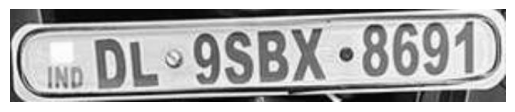

In [48]:
# load image
image = cv2.imread(img_path2)
image_g = toGray(image)
showImage(image_g)


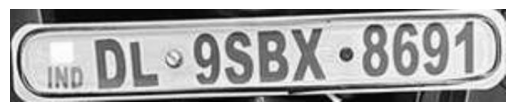

In [49]:
image_upscale = upscale_with_interpolation(image_g)
showImage(image_upscale)

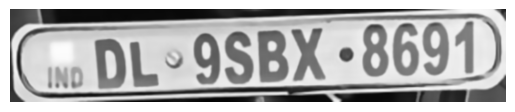

In [50]:
image_bilateral = apply_fast_nl_means_denoising(image_upscale)
showImage(image_bilateral)

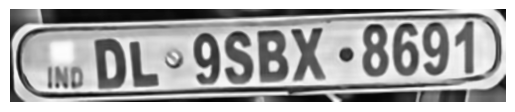

In [51]:
image_clache = apply_clahe(image_bilateral)
showImage(image_clache)

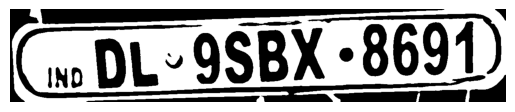

In [52]:
image_th = apply_threshold(image_clache)
showImage(image_th)

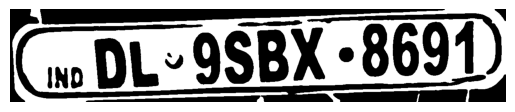

In [53]:
image_morphology = apply_morphology(image_th, operation='erode')
showImage(image_morphology)

Image Brightness: 127.76
Image Sharpness: 8813.51
Background Noise Level: 127.50





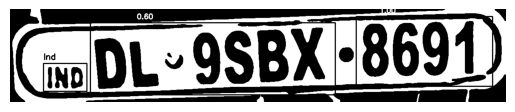


Detected Text: ['Ind', 'DL -9SBX', '8691']

OCR Results Table:
╒══════════╤═════════════════╤══════════════╕
│   Region │ Detected Text   │   conf score │
╞══════════╪═════════════════╪══════════════╡
│        0 │ Ind             │         0.83 │
├──────────┼─────────────────┼──────────────┤
│        1 │ DL -9SBX        │         0.6  │
├──────────┼─────────────────┼──────────────┤
│        2 │ 8691            │         1    │
╘══════════╧═════════════════╧══════════════╛


In [57]:
test_image = image_morphology
check_img_status(test_image)
print("\n\n")
apply_ocr(test_image)
